# Livrable 3

## 1. Introduction

Dans le cadre du projet **Leyenda**, l'objectif de ce livrable est de développer un système automatique capable de générer des légendes descriptives pour des photographies, en utilisant des techniques avancées d'apprentissage profond. Ce livrable s'appuie sur l'un des datasets de référence dans le domaine, **MS COCO**, qui contient des images annotées manuellement avec des descriptions textuelles détaillées.

Pour accomplir cette tâche, nous avons conçu un modèle de **réseau de neurones convolutionnel (CNN)** couplé à un **réseau de neurones récurrent (RNN)**. Le CNN est utilisé pour extraire les caractéristiques visuelles des images, tandis que le RNN, notamment un **modèle de type LSTM (Long Short-Term Memory)**, traite ces caractéristiques pour générer des séquences de mots, formant ainsi des légendes.

Le modèle suit un pipeline en plusieurs étapes, commençant par le prétraitement des images et des légendes textuelles, suivi de l'entraînement du modèle à partir des données étiquetées. Ce document détaille les différentes phases de développement, l'architecture du modèle, ainsi que les résultats obtenus lors des phases de test. 

L'objectif final de ce livrable est de présenter une solution automatisée, capable d'être déployée pour une utilisation dans des environnements réels, où elle pourrait analyser de nouvelles images et générer des légendes précises, en s'appuyant sur l'expérience acquise lors de l'entraînement sur MS COCO.

## 2. Importation et exploration des données

### 2.1. Code d'importation

Pour la réalisation de ce projet de captioning d'images, plusieurs librairies sont nécessaires afin de gérer les différentes étapes du traitement des données, de l'entraînement du modèle et de la visualisation des résultats.

In [1]:
import os, zipfile, random, json, collections, urllib, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

2024-10-23 07:24:08.302527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 07:24:08.310690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 07:24:08.319419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 07:24:08.322079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 07:24:08.328436: I tensorflow/core/platform/cpu_feature_guar

### 2.2. Configuration et initialisation des répertoires et paramètres

#### 1. Chemin du projet

In [2]:
project_path = os.getcwd() + '/livrable_3'

#### 2. Définition des chemins pour les données

In [3]:
paths = {
    "data_dir": os.path.join(project_path, "data"),
    "train_images_dir": os.path.join(project_path, "data", "train2014"),
    "annotations_dir": os.path.join(project_path, "data", "annotations"),
    "train_images_zip": os.path.join(project_path, "data", "train2014.zip"),
    "annotations_zip": os.path.join(project_path, "data", "annotations_trainval2014.zip"),
    "annotation_file": os.path.join(project_path, "data", "annotations", "captions_train2014.json"),
    "tokenizer_file": os.path.join(project_path, "data", "tokenizer.json"),
    "checkpoint_path": os.path.join(project_path, "data", "checkpoints"),
}

#### 3. Création du répertoire de données

In [4]:
if not os.path.exists(paths["data_dir"]):
    os.makedirs(paths["data_dir"])

#### 4. URL des fichiers du dataset COCO

In [5]:
COCO_URLs = {
    "images": "http://images.cocodataset.org/zips/train2014.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
}

#### 5. Paramètres du modèle

In [38]:
epochs = 100

batch_size = 32
buffer_size = 1000

embedding_dim = 256

units = 512

top_k = 10000
vocab_size = top_k + 1

### 2.3. Téléchargement et extraction des données COCO

L’un des prérequis essentiels pour entraîner un modèle de captioning est de disposer d'un dataset riche en images et légendes correspondantes. Dans ce projet, nous utilisons le dataset COCO 2014 qui contient un grand nombre d’images d’entraînement et des annotations sous forme de légendes textuelles. Ce bloc de code permet de gérer automatiquement le téléchargement et l'extraction de ces données dans l'environnement de travail.

In [7]:
def download_and_extract(zip_path, extract_dir, url, description):
    # Téléchargement du fichier zip si non présent
    if not os.path.exists(zip_path):
        print(f"Téléchargement du dataset COCO {description} en cours...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Téléchargement des {description} terminé.")
    else:
        print(f"Le fichier zip des {description} existe déjà.")

    # Vérification et extraction si nécessaire
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print(f"Extraction des fichiers {description} en cours...")
            zip_ref.extractall(os.path.dirname(extract_dir))
            print(f"Extraction des {description} terminée.")
    else:
        print(f"Les fichiers {description} ont déjà été extraits.")

    # Affichage du nombre de fichiers extraits
    if os.path.exists(extract_dir):
        extracted_files = os.listdir(extract_dir)
        print(f"{len(extracted_files)} fichiers extraits dans {extract_dir}")
    else:
        print(f"Erreur : le dossier d'extraction des {description} n'existe pas.")

# Téléchargement et extraction des images et annotations en générant les chemins à la volée
download_and_extract(
    paths["train_images_zip"],
    paths["train_images_dir"],
    COCO_URLs["images"],
    "images"
)

download_and_extract(
    paths["annotations_zip"],
    paths["annotations_dir"],
    COCO_URLs["annotations"],
    "annotations"
)

Le fichier zip des images existe déjà.
Les fichiers images ont déjà été extraits.
92467 fichiers extraits dans /tf/ProjetDeepLearning/livrable_3/data/train2014
Le fichier zip des annotations existe déjà.
Les fichiers annotations ont déjà été extraits.
6 fichiers extraits dans /tf/ProjetDeepLearning/livrable_3/data/annotations


### 2.5. Création de la correspondance image-légende

Ce bloc de code a pour objectif de créer une structure de données associant chaque image à ses légendes correspondantes à partir des annotations fournies dans le fichier JSON du dataset COCO. Cela permettra ensuite d’entraîner un modèle de captioning, où chaque image sera liée à une ou plusieurs légendes descriptives.

In [8]:
def create_image_caption_mapping(annotation_file, image_dir):
    # Lire le fichier d'annotation JSON
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    
    # Dictionnaire pour associer chaque image à ses légendes
    image_path_to_caption = collections.defaultdict(list)

    # Parcourir chaque annotation
    for annotation in annotations['annotations']:
        # Ajouter les balises de début et de fin à chaque légende
        caption = f"<start> {annotation['caption']} <end>"
        
        # Construire le chemin de l'image correspondant
        image_id = annotation['image_id']
        image_filename = f'COCO_train2014_{image_id:012d}.jpg'
        image_path = os.path.join(image_dir, image_filename)
        
        # Associer la légende à l'image
        image_path_to_caption[image_path].append(caption)

    return image_path_to_caption

image_path_to_caption = create_image_caption_mapping(
    paths["annotation_file"], 
    paths["train_images_dir"]
)

### 2.6. Sélection d'images et de légendes aléatoires

Ce bloc de code permet de sélectionner un échantillon aléatoire d'images et leurs légendes associées à partir du dictionnaire d'annotations précédemment généré. Cette étape est utile pour créer un sous-ensemble du dataset complet, souvent nécessaire lorsque l’entraînement est long ou que les ressources sont limitées.

In [9]:
def get_random_image_paths_and_captions(image_path_to_caption, num_samples=2000):
    # Prendre tous les chemins d'images
    image_paths = list(image_path_to_caption.keys())
    
    # Sélectionner un échantillon aléatoire d'images
    train_image_paths = random.sample(image_paths, num_samples)

    # Initialiser les listes pour les légendes et les chemins d'images dupliqués
    train_captions = []
    img_name_vector = []

    # Remplir les listes en fonction des annotations
    for image_path in train_image_paths:
        caption_list = image_path_to_caption[image_path]
        # Ajouter chaque légende dans train_captions
        train_captions.extend(caption_list)
        # Ajouter le chemin de l'image dupliqué selon le nombre d'annotations
        img_name_vector.extend([image_path] * len(caption_list))

    return img_name_vector, train_captions

img_name_vector, train_captions = get_random_image_paths_and_captions(image_path_to_caption, 5000)


25015 25015
<start> A group of people walking down a road with a bag of luggage. <end>


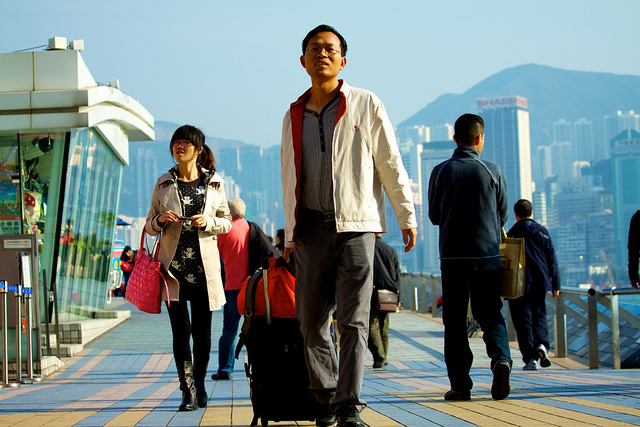

In [10]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

### 2.7. Création d’un extracteur de caractéristiques d’images

L'extraction des caractéristiques d'une image est une étape cruciale dans un pipeline de captioning d'images. Le modèle InceptionV3, pré-entraîné sur le dataset ImageNet, est couramment utilisé pour cette tâche car il est capable d'extraire des représentations denses et informatives d'images.

In [11]:
def create_image_feature_extractor():
    # Téléchargement du modèle InceptionV3 pré-entraîné sur ImageNet sans la couche supérieure
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

    # Récupérer l'entrée du modèle InceptionV3
    new_input = image_model.input

    # Récupérer la sortie de la dernière couche cachée (dense)
    hidden_layer = image_model.layers[-1].output

    # Créer un nouveau modèle qui extrait les caractéristiques denses des images
    image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

    return image_features_extract_model

image_features_extract_model = create_image_feature_extractor()

I0000 00:00:1729668251.662620    7034 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729668251.670129    7034 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729668251.670163    7034 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729668251.671519    7034 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729668251.671539    7034 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### 2.8. Prétraitement et extraction des caractéristiques des image

L'objectif de ce bloc de code est de prétraiter les images, d’extraire leurs caractéristiques à l'aide du modèle InceptionV3, et de sauvegarder ces caractéristiques sous forme de fichiers .npy pour une utilisation ultérieure dans le modèle de captioning.

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path

def save_image_features(batch_features, paths):
    for bf, p in zip(batch_features, paths):
        path_of_feature = p.numpy().decode("utf-8") 

        np.save(path_of_feature, bf.numpy())

# Pré-traitement des images
encode_train = sorted(set(img_name_vector))

# Créer un Dataset TensorFlow pour traiter les images par lots
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour extraire les caractéristiques des images
for img, path in tqdm(image_dataset):
    # Extraire les caractéristiques du batch actuel avec InceptionV3
    batch_features = image_features_extract_model(img)
    # Redimensionner les caractéristiques (16, 8, 8, 2048) en (16, 64, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    # Sauvegarder les caractéristiques extraites pour chaque image dans le batch
    save_image_features(batch_features, path)

  0%|          | 0/313 [00:00<?, ?it/s]2024-10-23 07:24:15.412284: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1729668255.472808    7034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729668255.487383    7034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729668255.487948    7034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729668255.491499    7034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729668255.492829    7034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729668255.493387    7034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729668255.518929    7034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W000

### 2.9. Prétraitement des légendes et sauvegarde du tokenizer

Ce bloc de code s’occupe de convertir les légendes d’entraînement en séquences de tokens, de les normaliser à une longueur commune, et de sauvegarder le tokenizer pour une utilisation ultérieure. Ce processus est essentiel pour préparer les légendes dans un format compréhensible par un modèle de machine learning.

In [13]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

def preprocess_captions(train_captions, top_k=5000):
    # Initialiser le tokenizer avec les paramètres spécifiques
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=top_k, 
        oov_token="<unk>", 
        filters=r'!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
        )
    
    # Construire le vocabulaire basé sur les légendes
    tokenizer.fit_on_texts(train_captions)

    # Ajouter un token spécial pour remplir les légendes courtes
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Convertir les légendes en séquences de tokens
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Remplir les séquences à la longueur maximale
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

    # Calculer la longueur maximale des séquences
    max_length = calc_max_length(train_seqs)

    return cap_vector, tokenizer, max_length

def save_tokenizer(tokenizer, save_path):
    tokenizer_json = tokenizer.to_json()
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    print(f'Tokenizer sauvegardé dans {save_path}.')

# Prétraitement des légendes d'entraînement
cap_vector, tokenizer, max_length = preprocess_captions(train_captions, top_k)

# Sauvegarder le tokenizer pour un usage ultérieur
tokenizer_save_path = paths["tokenizer_file"]
save_tokenizer(tokenizer, tokenizer_save_path)

Tokenizer sauvegardé dans /tf/ProjetDeepLearning/livrable_3/data/tokenizer.json.


### 2.10. Création de la correspondance image-légende et division du dataset

L’objectif de ce segment de code est de créer une structure de données qui associe chaque image à ses légendes correspondantes, puis de diviser le dataset en ensembles d’entraînement et de validation. Cette étape est essentielle pour évaluer les performances du modèle tout en évitant le surapprentissage.

In [14]:
def create_image_caption_mapping(img_name_vector, cap_vector):
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    
    return img_to_cap_vector

def split_dataset(img_to_cap_vector, split_ratio=0.8):
    # Récupérer les clés (chemins des images, sans doublons)
    img_keys = list(img_to_cap_vector.keys())
    random.shuffle(img_keys)  # Mélanger les clés

    # Diviser les indices selon le ratio défini
    slice_index = int(len(img_keys) * split_ratio)
    img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

    # Construire les listes d'entrainement et de validation
    img_name_train, cap_train = [], []
    img_name_val, cap_val = [], []

    # Boucle pour l'ensemble d'entraînement
    for imgt in img_name_train_keys:
        capt_len = len(img_to_cap_vector[imgt])
        img_name_train.extend([imgt] * capt_len)
        cap_train.extend(img_to_cap_vector[imgt])

    # Boucle pour l'ensemble de validation
    for imgv in img_name_val_keys:
        capv_len = len(img_to_cap_vector[imgv])
        img_name_val.extend([imgv] * capv_len)
        cap_val.extend(img_to_cap_vector[imgv])

    return img_name_train, cap_train, img_name_val, cap_val

# Association des images avec leurs légendes
img_to_cap_vector = create_image_caption_mapping(img_name_vector, cap_vector)

# Division du dataset en ensembles d'entraînement et de validation
img_name_train, cap_train, img_name_val, cap_val = split_dataset(img_to_cap_vector, split_ratio=0.8)

# Affichage des tailles des jeux d'entraînement et de validation
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

num_steps = len(img_name_train) // batch_size

### 2.11. Création du dataset d'entraînement avec préchargement des caractéristiques

Ce code gère la création d’un dataset TensorFlow à partir des chemins d’images et de leurs légendes. Les images ne sont pas directement chargées mais plutôt leurs caractéristiques extraites (sous forme de fichiers .npy), préalablement générées à l’aide du modèle InceptionV3.

In [15]:
# Les formes des vecteurs extraits de InceptionV3
features_shape = 2048
attention_features_shape = 64

def map_func(img_name, cap):
    img_path = img_name.decode('utf-8') + '.npy'
    if os.path.exists(img_path):
        img_tensor = np.load(img_path)
    else:
        raise FileNotFoundError(f"Le fichier {img_path} n'existe pas.")
    
    return img_tensor, cap

def create_dataset(img_names, captions, batch_size=batch_size, buffer_size=buffer_size):
    # Création du dataset à partir des images et des légendes
    dataset = tf.data.Dataset.from_tensor_slices((img_names, captions))

    # Utiliser map pour charger les fichiers numpy
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Mélanger les données et les diviser en batchs
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Création du dataset d'entraînement
dataset = create_dataset(img_name_train, cap_train)

## 3. Le modèle

### 3.1. Classe : CNN_Encoder

La classe CNN_Encoder est un encodeur d'images conçu pour transformer les caractéristiques extraites des images en une représentation adaptée à l'entrée dans un modèle séquentiel, tel qu'un réseau de neurones récurrent (RNN). Dans ce cas, les caractéristiques des images sont déjà extraites par InceptionV3 et ne nécessitent pas un traitement supplémentaire complexe. L'encodeur agit simplement comme un intermédiaire en réduisant la dimensionnalité et en appliquant une couche dense avec activation ReLU et un Dropout pour régulariser l'apprentissage.

In [16]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim, dropout_rate=0.5):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        return x

### 3.2. Classe : BahdanauAttention

La classe BahdanauAttention implémente le mécanisme d'attention proposé par Bahdanau et al. en 2015. L'attention permet au modèle de se concentrer sur certaines parties des données d'entrée (dans ce cas, les caractéristiques des images) en fonction de l'état caché courant du décodeur (par exemple, un RNN ou un LSTM). Cela améliore l'apprentissage en pondérant différemment les caractéristiques en fonction de leur pertinence pour générer la légende à chaque étape.

In [17]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, dropout_rate=0.5):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, features, hidden, training=False):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)
        attention_weights = self.dropout(attention_weights, training=training)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 3.3 Classe : RNN_Decoder

La classe RNN_Decoder implémente un décodeur basé sur un réseau de neurones récurrents (RNN), plus précisément un LSTM (Long Short-Term Memory), utilisé pour générer des séquences de texte à partir de caractéristiques d'images extraites et du vecteur de contexte fourni par un mécanisme d'attention. Cette classe fait partie d'un modèle de captioning d'images.

In [18]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # Remplacement de la couche GRU par LSTM
        self.lstm = tf.keras.layers.LSTM(self.units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden[0])

        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
        
        # Concaténation du vecteur de contexte et de l'embedding
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la LSTM
        output, hidden_state, cell_state = self.lstm(x, initial_state=hidden)

        # Couche dense après LSTM
        y = self.fc1(output)

        # Reshape du résultat
        y = tf.reshape(y, (-1, y.shape[2]))

        # Dernière couche dense pour obtenir la prédiction du vocabulaire
        y = self.fc2(y)

        return y, [hidden_state, cell_state], attention_weights

    def reset_state(self, batch_size):
        # Pour LSTM, initialiser deux états : hidden state et cell state
        return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

### 3.4. Création de l'encodeur

In [19]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)

### 3.5. Création du décodeur

In [20]:
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### 3.6. Optimiseur et fonction de perte

Ces éléments jouent un rôle clé dans la phase d'entraînement du modèle de captioning. L'optimiseur ajuste les poids du modèle pour minimiser la perte, et la fonction de perte mesure la différence entre les prédictions du modèle et les légendes réelles.

In [21]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 3.7. Gestion des checkpoints

Ce code permet de sauvegarder et de restaurer l'état du modèle à différents points pendant l'entraînement. Les checkpoints contiennent les poids du modèle (pour l'encodeur et le décodeur), ainsi que l'état de l'optimiseur, ce qui permet de reprendre l'entraînement à partir du dernier point de sauvegarde en cas d'interruption.

In [39]:
def setup_checkpoint(encoder, decoder, optimizer, max_to_keep=5):
    # Créer le checkpoint
    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, paths["checkpoint_path"], max_to_keep=max_to_keep)
    
    start_epoch = 0
    
    # Restaurer le dernier checkpoint s'il existe
    if ckpt_manager.latest_checkpoint:
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        print(f"Restoration du dernier checkpoint à l'époque {start_epoch}.")
        ckpt.restore(ckpt_manager.latest_checkpoint)
    else:
        print("Aucun checkpoint trouvé, entraînement à partir de zéro.")
    
    return ckpt_manager, start_epoch

ckpt_manager, start_epoch = setup_checkpoint(encoder, decoder, optimizer)


Restoration du dernier checkpoint à l'époque 10.


### 3.8. Fonction : train_step

La fonction train_step représente une étape unique d'entraînement du modèle, où une image et sa légende cible sont traitées pour mettre à jour les poids du modèle. Cette étape comprend la propagation avant (encodage des images, génération des légendes), le calcul de la perte, et la rétropropagation pour ajuster les poids à l'aide des gradients.

In [41]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur avec le token <start> pour chaque séquence
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:  # Calcul des gradients pour optimiser les poids du modèle
        # Encoder l'image (extraction des features avec l'encodeur)
        features = encoder(img_tensor)

        # Boucle sur chaque étape de la séquence (chaque mot)
        for i in range(1, target.shape[1]):
            # Prédiction du i-ème mot avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # Calcul de la perte pour cette étape (comparaison entre la vérité et la prédiction)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct est utilisé comme entrée pour la prochaine prédiction
            dec_input = tf.expand_dims(target[:, i], 1)

    # Calcul de la perte moyenne par séquence
    total_loss = loss / int(target.shape[1])

    # Liste des variables entraînables (encodeur et décodeur)
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Calcul des gradients en fonction de la perte
    gradients = tape.gradient(loss, trainable_variables)
    
    # Application des gradients pour mettre à jour les poids du modèle
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### 3.9. Fonction : train_model()

La fonction train_model() exécute l'entraînement du modèle de captioning d'images sur un nombre spécifié d'époques. À chaque époque, elle parcourt le dataset d'entraînement, met à jour les poids du modèle à l'aide des gradients, et sauvegarde les checkpoints périodiquement. Cette fonction affiche également la progression et le temps d'exécution pour chaque époque.

In [24]:
def train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager):
    loss_plot = []

    for epoch in range(start_epoch, epochs):
        start = time.time()
        total_loss = 0

        # Barre de progression pour l'epoch en cours
        with tqdm(total=num_steps, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:

            # Parcourir les batches d'entraînement
            for batch, (img_tensor, target) in enumerate(dataset):
                # Effectuer une étape d'entraînement
                batch_loss, t_loss = train_step(img_tensor, target)
                total_loss += t_loss

                # Mise à jour de la barre de progression
                pbar.set_postfix({"Batch Loss": f"{batch_loss.numpy() / int(target.shape[1]):.4f}"})
                pbar.update(1)

            # Sauvegarder la perte moyenne pour l'epoch
            loss_plot.append(total_loss / num_steps)

            # Sauvegarder les checkpoints tous les 5 epochs
            if epoch % 5 == 0:
                ckpt_manager.save()
                print(f'Checkpoint sauvegardé à l\'epoch {epoch + 1}')

        # Afficher la perte moyenne et le temps pris pour l'epoch
        print(f'\nEpoch {epoch + 1} Loss {total_loss / num_steps:.6f}')
        print(f'Temps pris pour l\'epoch {epoch + 1}: {time.time() - start:.2f} secondes\n')

    return loss_plot

# Lancer l'entraînement
loss_plot = train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager)

Epoch 11/100: 626batch [01:43,  6.05batch/s, Batch Loss=0.1018]                      


Checkpoint sauvegardé à l'epoch 11

Epoch 11 Loss 0.082618
Temps pris pour l'epoch 11: 103.48 secondes



Epoch 12/100: 626batch [01:26,  7.25batch/s, Batch Loss=0.1197]                      



Epoch 12 Loss 0.082872
Temps pris pour l'epoch 12: 86.29 secondes



Epoch 13/100: 626batch [01:25,  7.36batch/s, Batch Loss=0.0932]                      



Epoch 13 Loss 0.082733
Temps pris pour l'epoch 13: 85.04 secondes



Epoch 14/100: 626batch [01:22,  7.63batch/s, Batch Loss=0.0857]                      



Epoch 14 Loss 0.081890
Temps pris pour l'epoch 14: 82.06 secondes



Epoch 15/100: 626batch [01:24,  7.41batch/s, Batch Loss=0.1086]                      



Epoch 15 Loss 0.080843
Temps pris pour l'epoch 15: 84.44 secondes



Epoch 16/100: 626batch [01:24,  7.45batch/s, Batch Loss=0.1120]                      


Checkpoint sauvegardé à l'epoch 16

Epoch 16 Loss 0.080038
Temps pris pour l'epoch 16: 84.08 secondes



Epoch 17/100: 626batch [01:23,  7.49batch/s, Batch Loss=0.0997]                      



Epoch 17 Loss 0.079558
Temps pris pour l'epoch 17: 83.61 secondes



Epoch 18/100: 626batch [01:23,  7.46batch/s, Batch Loss=0.1040]                      



Epoch 18 Loss 0.079740
Temps pris pour l'epoch 18: 83.95 secondes



Epoch 19/100: 626batch [01:23,  7.51batch/s, Batch Loss=0.0932]                      



Epoch 19 Loss 0.079572
Temps pris pour l'epoch 19: 83.33 secondes



Epoch 20/100: 626batch [01:25,  7.31batch/s, Batch Loss=0.1056]                      



Epoch 20 Loss 0.078812
Temps pris pour l'epoch 20: 85.63 secondes



Epoch 21/100: 626batch [01:22,  7.60batch/s, Batch Loss=0.0766]                      


Checkpoint sauvegardé à l'epoch 21

Epoch 21 Loss 0.078517
Temps pris pour l'epoch 21: 82.40 secondes



Epoch 22/100: 626batch [01:22,  7.63batch/s, Batch Loss=0.0844]                      



Epoch 22 Loss 0.078519
Temps pris pour l'epoch 22: 82.06 secondes



Epoch 23/100: 626batch [01:20,  8.43batch/s, Batch Loss=0.0954]                      2024-10-23 09:11:44.736654: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 23/100: 626batch [01:20,  7.74batch/s, Batch Loss=0.0954]



Epoch 23 Loss 0.078284
Temps pris pour l'epoch 23: 80.86 secondes



Epoch 24/100: 626batch [01:22,  7.58batch/s, Batch Loss=0.0995]                      



Epoch 24 Loss 0.078494
Temps pris pour l'epoch 24: 82.63 secondes



Epoch 25/100: 626batch [01:23,  7.48batch/s, Batch Loss=0.0953]                      



Epoch 25 Loss 0.077034
Temps pris pour l'epoch 25: 83.68 secondes



Epoch 26/100: 626batch [01:22,  7.61batch/s, Batch Loss=0.1080]                      


Checkpoint sauvegardé à l'epoch 26

Epoch 26 Loss 0.077105
Temps pris pour l'epoch 26: 82.31 secondes



Epoch 27/100: 626batch [01:23,  7.50batch/s, Batch Loss=0.0751]                      



Epoch 27 Loss 0.076118
Temps pris pour l'epoch 27: 83.46 secondes



Epoch 28/100: 626batch [01:23,  7.48batch/s, Batch Loss=0.0934]                      



Epoch 28 Loss 0.076125
Temps pris pour l'epoch 28: 83.68 secondes



Epoch 29/100: 626batch [01:22,  7.57batch/s, Batch Loss=0.0765]                      



Epoch 29 Loss 0.075822
Temps pris pour l'epoch 29: 82.73 secondes



Epoch 30/100: 626batch [01:23,  7.45batch/s, Batch Loss=0.0874]                      



Epoch 30 Loss 0.075838
Temps pris pour l'epoch 30: 83.97 secondes



Epoch 31/100: 626batch [01:24,  7.40batch/s, Batch Loss=0.0793]                      


Checkpoint sauvegardé à l'epoch 31

Epoch 31 Loss 0.075057
Temps pris pour l'epoch 31: 84.57 secondes



Epoch 32/100: 626batch [01:22,  7.59batch/s, Batch Loss=0.1021]                      



Epoch 32 Loss 0.074951
Temps pris pour l'epoch 32: 82.49 secondes



Epoch 33/100: 626batch [01:23,  7.52batch/s, Batch Loss=0.0794]                      



Epoch 33 Loss 0.074941
Temps pris pour l'epoch 33: 83.22 secondes



Epoch 34/100: 626batch [01:23,  7.49batch/s, Batch Loss=0.0816]                      



Epoch 34 Loss 0.075237
Temps pris pour l'epoch 34: 83.62 secondes



Epoch 35/100: 626batch [01:24,  7.38batch/s, Batch Loss=0.1028]                      



Epoch 35 Loss 0.074222
Temps pris pour l'epoch 35: 84.82 secondes



Epoch 36/100: 626batch [01:27,  7.13batch/s, Batch Loss=0.1187]                      


Checkpoint sauvegardé à l'epoch 36

Epoch 36 Loss 0.073686
Temps pris pour l'epoch 36: 87.76 secondes



Epoch 37/100: 626batch [01:27,  7.19batch/s, Batch Loss=0.0899]                      



Epoch 37 Loss 0.073580
Temps pris pour l'epoch 37: 87.11 secondes



Epoch 38/100: 626batch [01:24,  7.37batch/s, Batch Loss=0.1013]                      



Epoch 38 Loss 0.073337
Temps pris pour l'epoch 38: 84.92 secondes



Epoch 39/100: 626batch [01:23,  7.52batch/s, Batch Loss=0.1075]                      



Epoch 39 Loss 0.073208
Temps pris pour l'epoch 39: 83.20 secondes



Epoch 40/100: 626batch [01:24,  7.40batch/s, Batch Loss=0.0770]                      



Epoch 40 Loss 0.073554
Temps pris pour l'epoch 40: 84.55 secondes



Epoch 41/100: 626batch [01:24,  7.38batch/s, Batch Loss=0.0814]                      


Checkpoint sauvegardé à l'epoch 41

Epoch 41 Loss 0.073702
Temps pris pour l'epoch 41: 84.86 secondes



Epoch 42/100: 626batch [01:24,  7.42batch/s, Batch Loss=0.0868]                      



Epoch 42 Loss 0.071944
Temps pris pour l'epoch 42: 84.31 secondes



Epoch 43/100: 626batch [01:24,  7.39batch/s, Batch Loss=0.0901]                      



Epoch 43 Loss 0.072109
Temps pris pour l'epoch 43: 84.72 secondes



Epoch 44/100: 626batch [01:23,  7.50batch/s, Batch Loss=0.0880]                      



Epoch 44 Loss 0.071341
Temps pris pour l'epoch 44: 83.49 secondes



Epoch 45/100: 626batch [01:22,  7.59batch/s, Batch Loss=0.0936]                      



Epoch 45 Loss 0.071777
Temps pris pour l'epoch 45: 82.47 secondes



Epoch 46/100: 626batch [01:25,  7.31batch/s, Batch Loss=0.1148]                      


Checkpoint sauvegardé à l'epoch 46

Epoch 46 Loss 0.072658
Temps pris pour l'epoch 46: 85.68 secondes



Epoch 47/100: 626batch [01:24,  7.42batch/s, Batch Loss=0.0829]                      



Epoch 47 Loss 0.072276
Temps pris pour l'epoch 47: 84.36 secondes



Epoch 48/100: 626batch [01:24,  7.37batch/s, Batch Loss=0.0834]                      



Epoch 48 Loss 0.071614
Temps pris pour l'epoch 48: 84.92 secondes



Epoch 49/100: 626batch [01:23,  7.54batch/s, Batch Loss=0.1119]                      



Epoch 49 Loss 0.070301
Temps pris pour l'epoch 49: 83.02 secondes



Epoch 50/100: 626batch [01:24,  7.43batch/s, Batch Loss=0.0829]                      



Epoch 50 Loss 0.070650
Temps pris pour l'epoch 50: 84.25 secondes



Epoch 51/100: 626batch [01:25,  7.32batch/s, Batch Loss=0.0812]                      


Checkpoint sauvegardé à l'epoch 51

Epoch 51 Loss 0.070466
Temps pris pour l'epoch 51: 85.49 secondes



Epoch 52/100: 626batch [01:23,  7.52batch/s, Batch Loss=0.0916]                      



Epoch 52 Loss 0.071046
Temps pris pour l'epoch 52: 83.20 secondes



Epoch 53/100: 626batch [01:23,  7.48batch/s, Batch Loss=0.0751]                      



Epoch 53 Loss 0.070899
Temps pris pour l'epoch 53: 83.69 secondes



Epoch 54/100: 626batch [01:24,  7.43batch/s, Batch Loss=0.0798]                      



Epoch 54 Loss 0.070345
Temps pris pour l'epoch 54: 84.24 secondes



Epoch 55/100: 626batch [01:24,  7.38batch/s, Batch Loss=0.0970]                      



Epoch 55 Loss 0.070651
Temps pris pour l'epoch 55: 84.79 secondes



Epoch 56/100: 626batch [01:25,  7.33batch/s, Batch Loss=0.1005]                      


Checkpoint sauvegardé à l'epoch 56

Epoch 56 Loss 0.069708
Temps pris pour l'epoch 56: 85.46 secondes



Epoch 57/100: 626batch [01:25,  7.35batch/s, Batch Loss=0.0746]                      



Epoch 57 Loss 0.069177
Temps pris pour l'epoch 57: 85.23 secondes



Epoch 58/100: 626batch [01:23,  7.47batch/s, Batch Loss=0.0911]                      



Epoch 58 Loss 0.069180
Temps pris pour l'epoch 58: 83.78 secondes



Epoch 59/100: 626batch [01:25,  7.33batch/s, Batch Loss=0.0802]                      



Epoch 59 Loss 0.068949
Temps pris pour l'epoch 59: 85.36 secondes



Epoch 60/100: 626batch [01:23,  7.46batch/s, Batch Loss=0.0954]                      



Epoch 60 Loss 0.069451
Temps pris pour l'epoch 60: 83.93 secondes



Epoch 61/100: 626batch [01:22,  7.58batch/s, Batch Loss=0.0934]                      


Checkpoint sauvegardé à l'epoch 61

Epoch 61 Loss 0.069750
Temps pris pour l'epoch 61: 82.62 secondes



Epoch 62/100: 626batch [01:24,  7.41batch/s, Batch Loss=0.0855]                      



Epoch 62 Loss 0.069456
Temps pris pour l'epoch 62: 84.46 secondes



Epoch 63/100: 626batch [01:24,  7.38batch/s, Batch Loss=0.0751]                      



Epoch 63 Loss 0.068773
Temps pris pour l'epoch 63: 84.80 secondes



Epoch 64/100: 626batch [01:22,  7.56batch/s, Batch Loss=0.0822]                      



Epoch 64 Loss 0.068457
Temps pris pour l'epoch 64: 82.78 secondes



Epoch 65/100: 626batch [01:25,  7.33batch/s, Batch Loss=0.0782]                      



Epoch 65 Loss 0.068123
Temps pris pour l'epoch 65: 85.36 secondes



Epoch 66/100: 626batch [01:26,  7.27batch/s, Batch Loss=0.0830]                      


Checkpoint sauvegardé à l'epoch 66

Epoch 66 Loss 0.067600
Temps pris pour l'epoch 66: 86.07 secondes



Epoch 67/100:  73%|███████▎  | 457/625 [01:03<00:21,  7.70batch/s, Batch Loss=0.0686]

### 3.10. Fonction : plot_metrics()

La fonction plot_metrics() est utilisée pour tracer la courbe de la perte d'entraînement au fil des époques. Bien que dans cet exemple seule la perte soit tracée, la fonction est conçue pour permettre l'ajout d'autres courbes, comme la précision ou le score BLEU, si nécessaire.

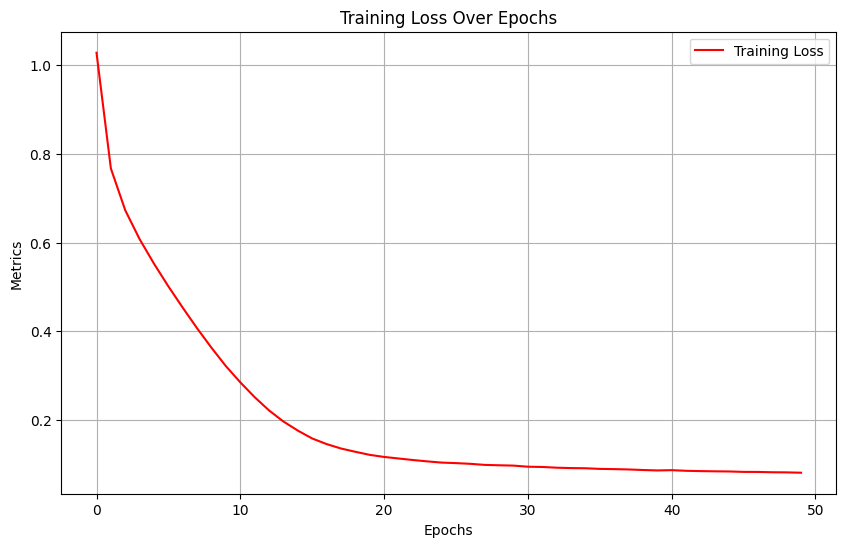

In [25]:
def plot_metrics(loss_plot):
    plt.figure(figsize=(10, 6))
    
    # Tracer la courbe de la perte
    plt.plot(loss_plot, label='Training Loss', color='r')
    
    # Tracer la courbe de la précision
    # plt.plot(accuracy_plot, label='Training Accuracy', color='g')
    
    # Tracer la courbe du score BLEU
    # plt.plot(bleu_plot, label='Training BLEU', color='b')

    # Ajouter des titres et labels
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training Loss Over Epochs')

    # Ajouter la grille pour faciliter la lecture
    plt.grid(True)

    # Ajouter la légende
    plt.legend()

    # Afficher le plot
    plt.show()

# Appeler la fonction pour afficher les courbes
plot_metrics(loss_plot)

## 4. Test

In [26]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    # Charger et pré-traiter l'image
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Passer l'image à l'encodeur
    features = encoder(img_tensor_val)

    # Initialiser l'entrée du décodeur avec le token <start>
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # Prédire le mot suivant
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Sauvegarder les poids d'attention
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Sélectionner l'ID du mot prédit avec argmax pour des prédictions plus déterministes
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        result.append(tokenizer.index_word.get(predicted_id, '<unk>'))

        if tokenizer.index_word.get(predicted_id) == '<end>':
            attention_plot = attention_plot[:len(result), :]
            return result, attention_plot

        # Mettre à jour l'entrée pour le prochain mot
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    grid_size = int(np.ceil(np.sqrt(len_result)))

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(grid_size, grid_size, l+1) 
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Image ID: 4380
Real Caption: <start> elephants being bathed in a body of water by people in sun hats <end>
Prediction Caption: a group of people on surfboards on a body of water <end>


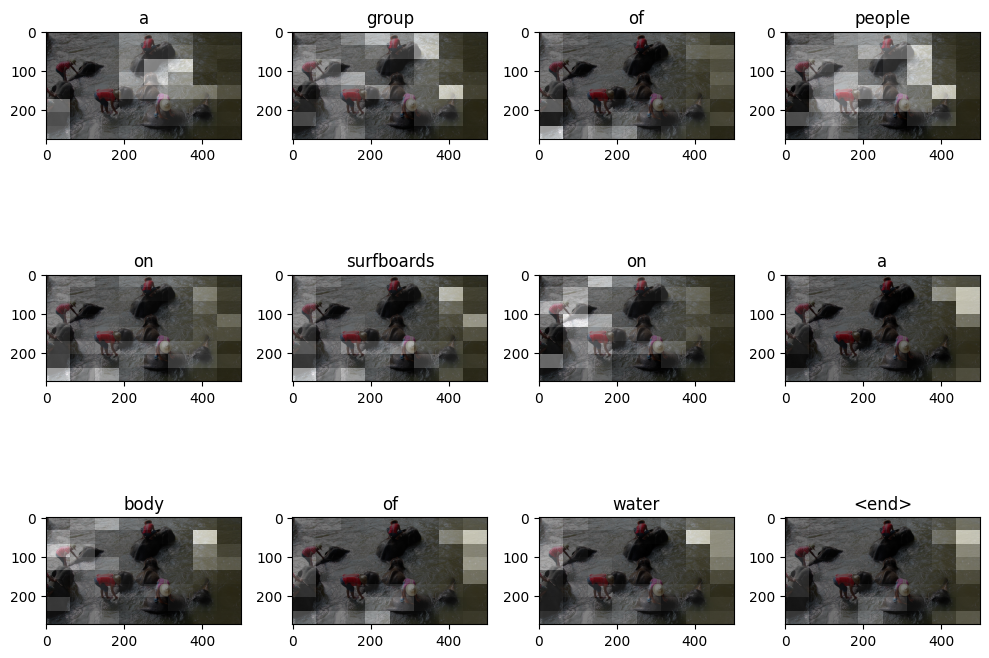

In [36]:
def display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1):
    for _ in range(num_samples):
        rid = np.random.randint(0, len(img_name_val))
        image = img_name_val[rid]

        # Générer la légende réelle
        real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

        # Prédire la légende avec le modèle
        result, attention_plot = evaluate(image)

        # Afficher la légende réelle et la légende prédite
        print(f"\nImage ID: {rid}")
        print(f"Real Caption: {real_caption}")
        print(f"Prediction Caption: {' '.join(result)}")

        # Visualiser l'attention
        plot_attention(image, result, attention_plot)

display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1)

In [37]:
#save the model (encoder and decoder)

encoder.save('./model/encoder_livrable_3.model.keras')
decoder.save('decoder_livrable_3.model.keras')